# Function Approximation with Neural Networks

One significant use of neural networks is in **approximating** the values of **continuous functions**. Particularly in areas like Deep Reinforcement Learning over continuous/high-dimensional state-spaces. 

For example, **Reinforcement Learning** algorithms like **Deep Q Learning** or **Fitted Value Iteration** can use neural networks to approximate Q functions, policies or value functions.

### References

[1] Cybenko, G. (1989). Approximation by superpositions of a sigmoidal function. Mathematics of Control, Signals, and Systems, 2(4), 303–314. doi:10.1007/bf02551274 

[2] https://en.wikipedia.org/wiki/Backpropagation

## A Universal Approximation Theorem

In the context of Artificial Neural Networks, universal approximation theorems concern the ability of feedforward networks to approximate certain classes of functions. Let us take a look at one specific class of neural networks - those with a single hidden layer of neurons with sigmoidal activation functions.

A sigmoidal

One specific theorem is as following [1]:


Now, for our practical purposes, this is more of a novelty; the theorem says nothing about the **required network size** or whether approximations can be obtained by **any specific learning algorithm**. 

Other such theorems build up support for the **existence** of neural networks as function approximators but let's look at some data to examine their practical performance under **standard learning algorithms** (i.e. backpropagation), 

## A Parabola

Let's get a basic parabola:


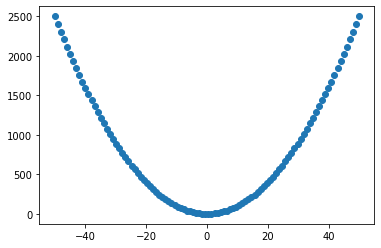

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-50, 50, 100)
y = x**2

plt.scatter(x, y)



Now let's try with a neural network.

### \[Tangent\] A Neural Network from Scratch

As our target problem is fairly basic and doesn't require high-performance, let's attempt making a neural network from scratch.

In [117]:
from math import exp


class Layer:
    
    def __init__(self, size):
        self.neurons = []
        self.size = size
        self.next_layer = None
        self.prev_layer = None
        
    def output(self):
        
        result = []
        
        for neuron in self.neurons:
            result.append(neuron.value)
            
        print(result)
                

class DenseLayer(Layer):
    
    
    def __init__(self, neuron_count, activation_function, prev_layer):
        
        super().__init__(neuron_count)
        
        
        # Handle connection with previous layer
        self.prev_layer = prev_layer
        prev_layer.next_layer = self
        
        # Creates Neurons
        for i in range(neuron_count):
            
            new_neuron = Neuron(activation_function, np.random.rand(prev_layer.size), np.random.rand())
            
            self.neurons.append(new_neuron)
            
            # Connects this neuron in a dense fashion to the previous layer
            for neuron in prev_layer.neurons:
                
                new_neuron.back_conns.append(neuron)
                neuron.forward_conns.append(new_neuron)
                
    def forward_propagate(self):

        for i in self.neurons:
            i.process()
            i.send_forward()

        if self.next_layer:
            self.next_layer.forward_propagate()
            
    
                
class InputLayer(Layer):
    
    def __init__(self, input_size):
        
        super().__init__(input_size)
        
        for i in range(input_size):
            self.neurons.append(Neuron())
    
    def forward_propagate(self, input):
        
             
        if len(input) != len(self.neurons):
            print('Input Dimension Error!')
            return
        
        for i in range(len(input)):
            self.neurons[i].value = input[i]
            self.neurons[i].send_forward()
            
        if self.next_layer:
            self.next_layer.forward_propagate()
        

class Neuron:
    
    def __init__(self, activation_function=None, weight=None, bias=None):
        
        self.forward_conns = []
        self.back_conns = []
        self.weight = weight
        self.bias = bias
        self.input = []
        self.activation_function = activation_function
        self.value = None
    
    def process(self):
        
        arr = np.array(self.input)
        
        if len(self.input) == 0:
            print('Error! Uninitialised Node.')
            return
        
        if self.activation_function == None:
            print('No Activation Function')
            return
        
        if arr.shape != self.weight.shape:
            print('Invalid Weight')
            print(self.weight) 
            print(arr)
            return
        
        if self.bias == None:
            print('Invalid Bias')
            return
        
        
        
        
        result = np.dot(arr,self.weight) + self.bias
        self.value = self.activation_function(result)
        
            
    def send_forward(self):
        for neuron in self.forward_conns:
            neuron.input.append(self.value)
        
    
def sigmoid(x):
    return (1/(1+exp(-x)))

In [118]:
first_layer = InputLayer(4)
prev_layer = first_layer
for i in range(10):
    layer = DenseLayer(8, sigmoid, prev_layer)
    prev_layer = layer

In [119]:
first_layer.forward_propagate([1,2,3,4])

In [120]:
first_layer.output()

[1, 2, 3, 4]


In [121]:
layer.output()

[0.9792439504432007, 0.9806157732132809, 0.9944067349044886, 0.9901381298429864, 0.9982045589365947, 0.9914067166454952, 0.9949419980887186, 0.9904242290749925]


So now that we've achieved basic forward propagation with arbitrary activation functions between dense layers, let's consider what our cost function could look like for function approximation.

We're performing a regression-style problem so, like with linear regression, let's try squared error:

Let's outline a derivation (using the Wikipedia [2] approach for weights but including the bias calculations):

$$ Let\ \sigma(x)=\frac{1}{1+e^{-x}}\ be\ the\ sigmoid\ function$$
$$ Let\ L(y,\hat{y}) = (y-\hat{y})^2\ be\ our\ squared\ error\ loss\ function\ where\ \hat{y}\ is\ the\ network's\ estimate\ and\ y\ is\ the\ true\ value $$
$$ Let\ w\ and\ b\ represent\ weights\ and\ biases\ respectively$$
The output of some neuron j is given by:
$$ o_j = \sigma((\sum_{k=1}^{n}w_{kj}o_{k}) + b_j)$$

Now:

$$ \frac{d\sigma (x)}{dx}= \frac{-(-e^{-x})}{(1+e^{-x})^2}= \frac{1+e^{-x}-1}{(1+e^{-x})^2}=\sigma(x)(1-\sigma(x))$$

Let's now calculate the derivative of the loss function with respect to the weights and biases:

First, the weights (using the chain rule for partial derivatives):

$$ \frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial w_{ij}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial w_{ij}}\quad where\ linear_{j}\ is\ the\ linear\ input\ to\ the\ \sigma\ function\ for\ neuron\ j\quad (1)$$

$$ \frac{\partial\ linear_{j}}{\partial w_{ij}} =  \frac{\partial}{\partial w_{ij}}((\sum_{k=1}^{n}w_{kj}o_{k}) + b_j) =  \frac{\partial}{\partial w_{ij}}w_{ij}o_{i} = o_i\quad (2)$$

$$ \frac{\partial o_j}{\partial\ linear_{j}} = \frac{\partial\ \sigma(linear_{j})}{\partial\ linear_{j}} = \sigma(linear_{j})(1-\sigma(linear_{j}))\quad (shown\ above)\quad (3)$$

Secondly, the biases (using the chain rule for partial derivatives):

$$ \frac{\partial L}{\partial b_{j}} = \frac{\partial E}{\partial o_{j}}\frac{\partial o_{j}}{\partial b_{j}} = \frac{\partial E}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial b_{j}}\quad (4)$$

$$ \frac{\partial\ linear_{j}}{\partial b_{j}} =  \frac{\partial}{\partial b_{j}}((\sum_{k=1}^{n}w_{kj}o_{k}) + b_j) =  1\quad (5)$$


Now, here comes the genius of backpropagation:

In the last (output) layer - a single node for our network,   $ o_j = \hat{y} $

So: 

$$ \frac{\partial L}{\partial o_j} = \frac{\partial L}{\partial \hat{y}} = \frac{\partial }{\partial \hat{y}}(\frac{1}{2}(y-\hat{y})^2) = \hat{y} - y\quad (6)$$

Now, if we consider j being a neuron in any other layer:

L is still a function of $ o_j $ because L is dependent on all the neurons receiving input from j:

So:

$$ \frac{\partial L}{\partial o_j} = \frac{\partial L(linear_a,linear_b, ...)}{\partial o_j}\ where\ neurons\ in\ P=\{ a,b,...\}\ receive\ input from\ neuron\ j $$

Now, the linear components are all functions of $o_j$ so are dependent on one another.

Therefore we need to take the **total derivative** to find this:

$$ \frac{\partial L}{\partial o_j} = \sum_{p \in P}(\frac{\partial L}{\partial linear_p}\frac{\partial linear_p}{\partial o_j}) = \sum_{p \in P}(\frac{\partial L}{\partial o_p}\frac{\partial o_p}{\partial linear_p}\frac{\partial linear_p}{\partial o_j}) = \sum_{p \in P}(\frac{\partial L}{\partial o_p}\frac{\partial o_p}{\partial linear_p}w_{jp}) \quad (7)$$

So this term is recursively dependent on those of neurons in P.

Now we have everything we need to find our partial derivatives for gradient descent.

**For the weights:**

Using Equations, 1,2,3,4,5:

$$\frac{\partial L}{\partial w_{ij}}  = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial w_{ij}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}o_i$$

And we assign:

$$\delta_j = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}} =   
\left\{
\begin{array}{ll}
      (o_j-\hat{y})o_j(1-o_j) & if\ j\ is\ an\ output\ neuron\\
      (\sum_{p\in P}(\frac{\partial L}{\partial o_p}\frac{\partial o_p}{\partial linear_p}w_{jp}))o_j(1-o_j) & if\ j\ is\ an\ inner\ neuron\\
\end{array} 
\right. 
= \left\{
\begin{array}{ll}
      (o_j-\hat{y})o_j(1-o_j) & if\ j\ is\ an\ output\ neuron\\
      (\sum_{p\in P}(w_{jp}\delta_{p}))o_j(1-o_j) & if\ j\ is\ an\ inner\ neuron\\
\end{array} 
\right. 
$$


**Let's do the same with biases:**

$$\frac{\partial L}{\partial b_{j}}  = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial b_{j}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}$$

So:

$$\frac{\partial L}{\partial w_{ij}} = o_i\delta_j $$

$$\frac{\partial L}{\partial b_{j}} = \delta_j $$

Now we can perform gradient descent to improve our neural network over time by 'back-propagating' through the network and adjusting weights/biases proportional to the negative of these derivatives. The constand of proportionality is called the **'learning rate'**.

In [310]:
from math import exp


class Layer:
    
    def __init__(self, size):
        self.neurons = []
        self.size = size
        self.next_layer = None
        self.prev_layer = None
        
    def output(self):
        
        result = []
        
        for neuron in self.neurons:
            result.append(neuron.result)
            
        print(result)
        
    def layer_info(self):
        
        if self.prev_layer == None:
            print('Input Layer')
            return
        
        for i in range(len(self.neurons)):
            print('%d: %f' % (i, self.neurons[i].bias))
            print(self.neurons[i].weight)
                

class DenseLayer(Layer):
    
    
    def __init__(self, neuron_count, activation_function, prev_layer):
        
        super().__init__(neuron_count)
        
        
        # Handle connection with previous layer
        self.prev_layer = prev_layer
        prev_layer.next_layer = self
        
        # Creates Neurons
        for i in range(neuron_count):
            
            new_neuron = Neuron(activation_function, (np.random.rand(prev_layer.size)-0.5)*5, (np.random.rand()-0.5)*5)
            
            self.neurons.append(new_neuron)
            
            # Connects this neuron in a dense fashion to the previous layer
            for neuron in prev_layer.neurons:
                
                new_neuron.back_conns.append(neuron)
                neuron.forward_conns.append(new_neuron)
                
    def forward_propagate(self,layer):
        
        print('Layer ', layer)

        for i in self.neurons:
            i.process()
            i.send_forward()

        if self.next_layer:
            self.next_layer.forward_propagate(layer+1)
            
    def back_propagate(self,true):
        
        for i in self.neurons:
            i.backprop(true)
            
        self.prev_layer.back_propagate(true)
            
    
                
class InputLayer(Layer):
    
    def __init__(self, input_size):
        
        super().__init__(input_size)
        
        for i in range(input_size):
            self.neurons.append(Neuron())
    
    def forward_propagate(self, input):
        
        
        if len(input) != len(self.neurons):
            print('Input Dimension Error!')
            return
        
        for i in range(len(input)):
            self.neurons[i].value = input[i]
            self.neurons[i].send_forward()
            
        if self.next_layer:
            self.next_layer.forward_propagate(1)
            
    # The input layer doesn't need to perform backprop
    def back_propagate(self, true):
        return
        

class Neuron:
    
    def __init__(self, activation_function=None, weight=None, bias=None):
        
        self.forward_conns = []
        self.back_conns = []
        self.weight = weight
        self.bias = bias
        self.input = []
        self.saved_input = None
        self.activation_function = activation_function
        self.value = None
        self.delta = None
    
    def process(self):
        arr = np.array(self.input)
        
        if len(self.input) == 0:
            print('Error! Uninitialised Node.')
            return
        
        if self.activation_function == None:
            print('No Activation Function')
            return
        
        if arr.shape != self.weight.shape:
            print('Invalid Weight')
            print(self.weight) 
            print(arr)
            return
        
        if self.bias == None:
            print('Invalid Bias')
            return
        
        
        
        self.result = np.dot(arr,self.weight) + self.bias
        self.saved_input = self.input
        self.input = []
        self.value = self.activation_function(self.result)
        
    def backprop(self, true):
        
        
        
        if len(self.forward_conns) == 0:
            self.delta = (self.value-true)*self.value*(1-self.value)
            
        else:
            delta_sum = 0
            for i in self.forward_conns:
                delta_sum += i.weight_delta_product[self]
            self.delta = delta_sum*self.value*(1-self.value)
        
        self.weight_delta_product = {}
        for i in range(len(self.back_conns)):
            self.weight_delta_product[self.back_conns[i]] = self.weight[i]*self.delta
        
        self.bias += -1*LEARNING_RATE*self.delta
        self.weight = np.add(np.array(self.saved_input)*self.delta*-1*LEARNING_RATE,self.weight)
            
        
            
    def send_forward(self):
        for neuron in self.forward_conns:
            neuron.input.append(self.value)
        

In [319]:
LEARNING_RATE = 0.01

In [320]:
first_layer = InputLayer(1)
prev_layer = first_layer
for i in range(1):
    layer = DenseLayer(8, sigmoid, prev_layer)
    prev_layer = layer
last_layer = DenseLayer(1,sigmoid,prev_layer)

In [321]:
for i in range(1000):
    x = (np.random.rand()-0.5)*50
    first_layer.forward_propagate([x])
    last_layer.back_propagate(x**2)

Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
L

Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
Layer  1
Layer  2
L

In [322]:
first_layer.forward_propagate([0])

Layer  1
Layer  2


In [323]:
last_layer.output()

[8.331928079100754]


In [316]:
first_layer.next_layer.layer_info()

0: -1.715583
[1.34510781]
1: -2.068739
[1.53496051]
2: 2.196332
[3.55271239]
3: 0.066707
[-0.3715733]
4: -0.901708
[-1.83584387]
5: 0.884491
[-1.34717331]
6: 1.850817
[-2.0868158]
7: -0.212303
[1.73425659]


In [317]:
last_layer.layer_info()

0: -1.155703
[0.88509773 4.27982535 1.12331407 0.59011223 2.44880815 2.77732004
 2.43062813 2.06525623]


In [318]:
first_layer.next_layer.output()

[1.3451078109184076, 1.5349605072949841, 3.5527123942122594, -0.3715733008667396, -1.8358438704842304, -1.347173312170075, -2.086815797904279, 1.734256588058802]
